In [14]:
import os
import cv2
import numpy as np
from skimage.measure import label, regionprops

# Paths
roi_folder = 'Dataset/Region of Interest/N1_ROI'
mask_folder = 'Segmented/N1_Native_Segmentation/Masks'

# Output count dictionary
capillary_counts = {}

# Get list of ROI images
roi_files = [f for f in os.listdir(roi_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

for roi_file in roi_files:
    roi_path = os.path.join(roi_folder, roi_file)
    roi_img = cv2.imread(roi_path)

    if roi_img is None:
        print(f"Could not read {roi_file}")
        continue

    # Derive corresponding mask filename
    base_name = os.path.splitext(roi_file)[0]
    mask_filename = base_name + "_Natif.jpg"
    mask_path = os.path.join(mask_folder, mask_filename)

    if not os.path.exists(mask_path):
        print(f"Skipping {roi_file} — no matching segmented mask file found.")
        continue

    # Read mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        print(f"Could not read mask: {mask_filename}")
        continue

    # Create ROI mask from black line (assumes black line = [0,0,0])
    roi_gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    _, roi_bin = cv2.threshold(roi_gray, 5, 255, cv2.THRESH_BINARY_INV)

    # Optional: Clean up ROI mask
    roi_bin = cv2.morphologyEx(roi_bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Apply ROI to mask
    roi_area_mask = cv2.bitwise_and(mask_img, roi_bin)

    # Binarize final mask
    _, binary_roi = cv2.threshold(roi_area_mask, 127, 255, cv2.THRESH_BINARY)

    # Count connected components (capillaries)
    labeled_mask = label(binary_roi)
    count = len([region for region in regionprops(labeled_mask) if region.area > 5])

    # Save result
    capillary_counts[roi_file] = count
    print(f"{roi_file}: {count} capillaries detected in ROI")

# Final summary (optional)
print("\n--- Capillary Counts Summary ---")
for fname, count in capillary_counts.items():
    print(f"{fname}: {count}")


N1a.jpg: 7 capillaries detected in ROI
N1b.jpg: 5 capillaries detected in ROI
N1c.jpg: 3 capillaries detected in ROI
N1d.jpg: 7 capillaries detected in ROI
N1e.jpg: 5 capillaries detected in ROI
N1f.jpg: 4 capillaries detected in ROI
N1g.jpg: 4 capillaries detected in ROI
N1h.jpg: 3 capillaries detected in ROI
N1i.jpg: 4 capillaries detected in ROI
N1j.jpg: 6 capillaries detected in ROI

--- Capillary Counts Summary ---
N1a.jpg: 7
N1b.jpg: 5
N1c.jpg: 3
N1d.jpg: 7
N1e.jpg: 5
N1f.jpg: 4
N1g.jpg: 4
N1h.jpg: 3
N1i.jpg: 4
N1j.jpg: 6


In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from skimage.measure import label, regionprops

def rotate_image(image, angle, center):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotated

# === PATH SETUP ===
base_output = 'Counting'
roi_folder = 'Dataset/Region of Interest/N1_ROI'
mask_folder = 'Segmented/N1_Native_Segmentation/Masks'
visuals_folder = os.path.join(base_output, 'Visualizations', 'N1')
csv_output_path = os.path.join(base_output, 'CSV', 'N1_capillary_counts.csv')

os.makedirs(visuals_folder, exist_ok=True)
os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)

capillary_counts = []
roi_files = [f for f in os.listdir(roi_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

for roi_file in roi_files:
    roi_path = os.path.join(roi_folder, roi_file)
    roi_img = cv2.imread(roi_path)
    if roi_img is None:
        print(f"Could not read {roi_file}")
        continue

    base_name = os.path.splitext(roi_file)[0]
    mask_filename = base_name + "_Natif.jpg"
    mask_path = os.path.join(mask_folder, mask_filename)

    if not os.path.exists(mask_path):
        print(f"Skipping {roi_file} — no matching mask found.")
        continue

    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        print(f"Could not read mask: {mask_filename}")
        continue

    # === DETECT BLACK LINE ===
    gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No ROI line found in {roi_file}")
        continue

    roi_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(roi_contour)
    box = cv2.boxPoints(rect).astype(np.intp)

    angle = rect[2]
    if angle < -45:
        angle += 90

    center = tuple(np.array(roi_img.shape[1::-1]) / 2)
    roi_rotated = rotate_image(roi_img, angle, center)
    mask_rotated = rotate_image(mask_img, angle, center)

    # === Recalculate box in rotated image ===
    gray_rotated = cv2.cvtColor(roi_rotated, cv2.COLOR_BGR2GRAY)
    _, binary_rotated = cv2.threshold(gray_rotated, 20, 255, cv2.THRESH_BINARY_INV)
    contours_rot, _ = cv2.findContours(binary_rotated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    roi_contour_rot = max(contours_rot, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(roi_contour_rot)

    # === Create ROI ABOVE black line ===
    roi_height = int(h * 4)  # adjust if needed
    new_y = max(0, y - roi_height)
    roi_box_mask = mask_rotated[new_y:y, x:x+w]

    # === SAFETY CHECK for empty ROI ===
    if roi_box_mask.size == 0 or roi_box_mask.shape[0] < 5 or roi_box_mask.shape[1] < 5:
        print(f"[Warning] Empty or too small ROI for {roi_file}. Skipping.")
        continue

    # === Count capillaries ===
    _, binary_roi = cv2.threshold(roi_box_mask, 127, 255, cv2.THRESH_BINARY)
    labeled = label(binary_roi)
    props = [p for p in regionprops(labeled) if p.area > 5]
    count = len(props)
    capillary_counts.append([roi_file, count])

    # === Visualization ===
    vis_img = cv2.cvtColor(mask_rotated, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(vis_img, (x, new_y), (x + w, y), (255, 0, 0), 2)
    cv2.drawContours(vis_img, [roi_contour_rot], -1, (0, 0, 255), 1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{roi_file} — {count} Capillaries", fontsize=14)

    axs[0].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original ROI")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(roi_rotated, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Rotated ROI + Bounding Box")
    axs[1].axis('off')

    axs[2].imshow(vis_img)
    axs[2].set_title("Capillary ROI Region")
    axs[2].axis('off')

    vis_path = os.path.join(visuals_folder, base_name + "_rotated_visual.png")
    plt.tight_layout()
    plt.savefig(vis_path)
    plt.close()

    print(f"{roi_file}: {count} capillaries detected. Visualization saved.")

# === SAVE CSV ===
with open(csv_output_path, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image Filename", "Capillary Count"])
    writer.writerows(capillary_counts)

print("\n✅ CSV Saved:", csv_output_path)


[Warning] Empty or too small ROI for N1a.jpg. Skipping.
[Warning] Empty or too small ROI for N1b.jpg. Skipping.
[Warning] Empty or too small ROI for N1c.jpg. Skipping.
[Warning] Empty or too small ROI for N1d.jpg. Skipping.
[Warning] Empty or too small ROI for N1e.jpg. Skipping.
[Warning] Empty or too small ROI for N1f.jpg. Skipping.
[Warning] Empty or too small ROI for N1g.jpg. Skipping.
[Warning] Empty or too small ROI for N1h.jpg. Skipping.
[Warning] Empty or too small ROI for N1i.jpg. Skipping.
[Warning] Empty or too small ROI for N1j.jpg. Skipping.

✅ CSV Saved: Counting\CSV\N1_capillary_counts.csv


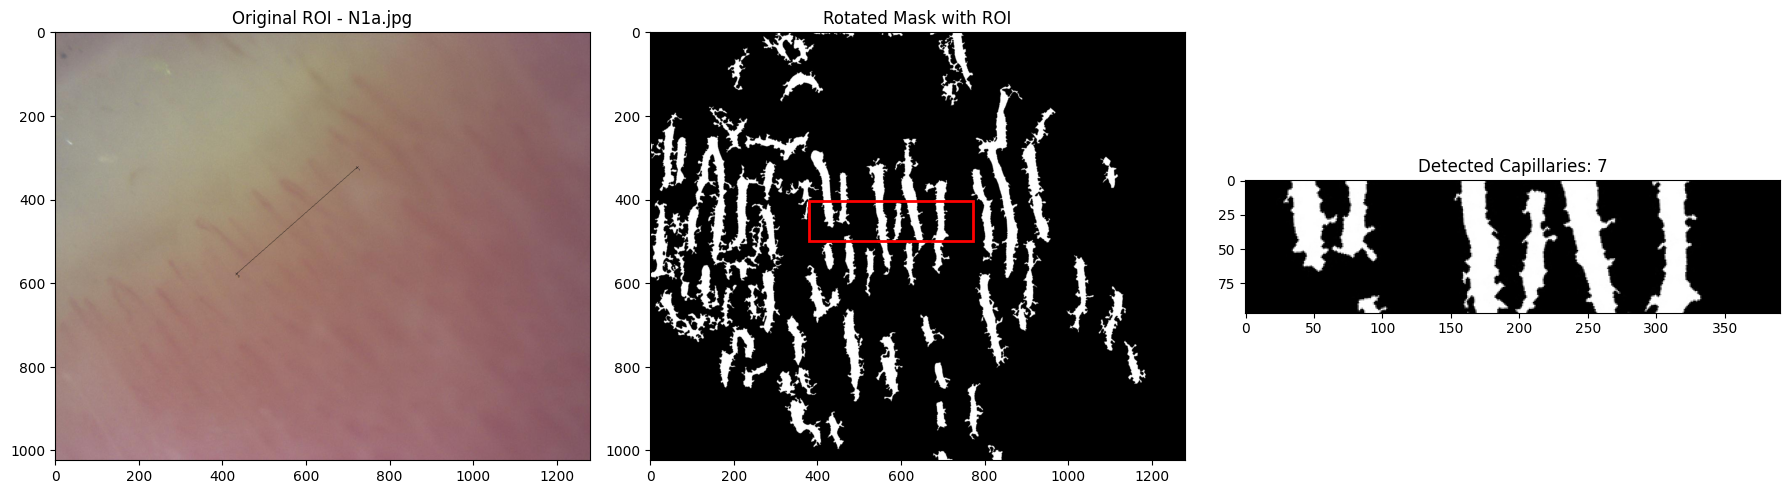

N1a.jpg: 7 capillaries detected in ROI


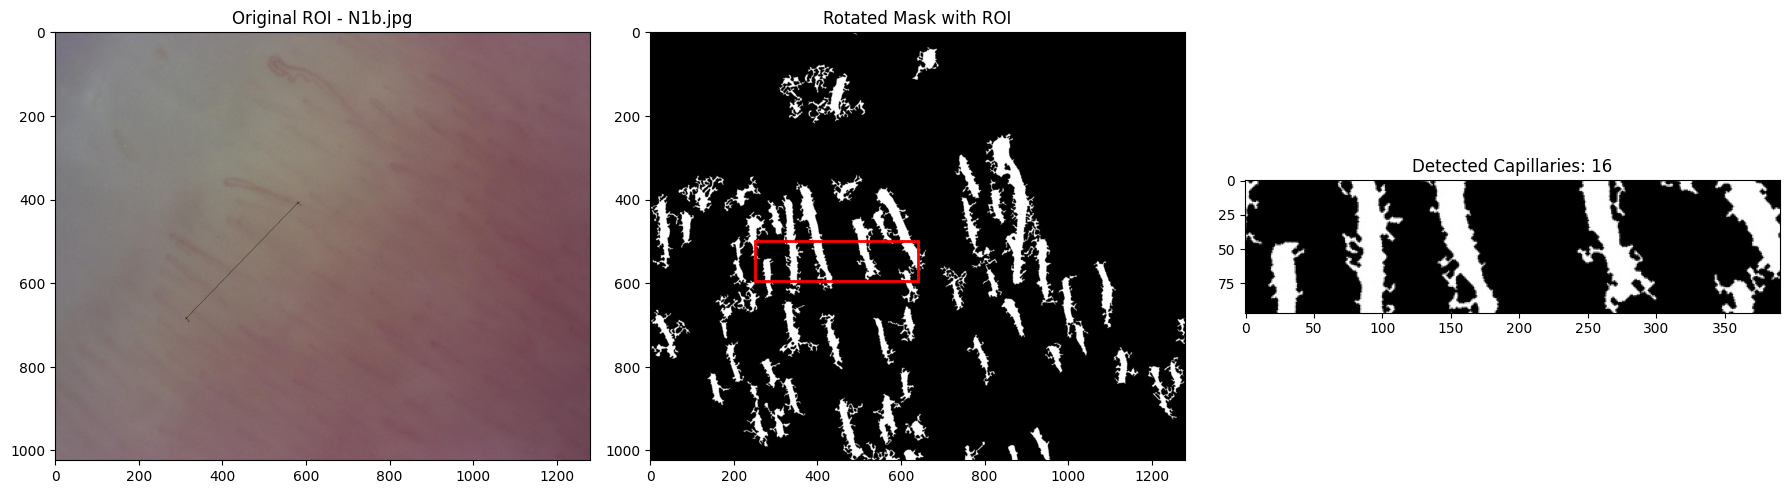

N1b.jpg: 16 capillaries detected in ROI


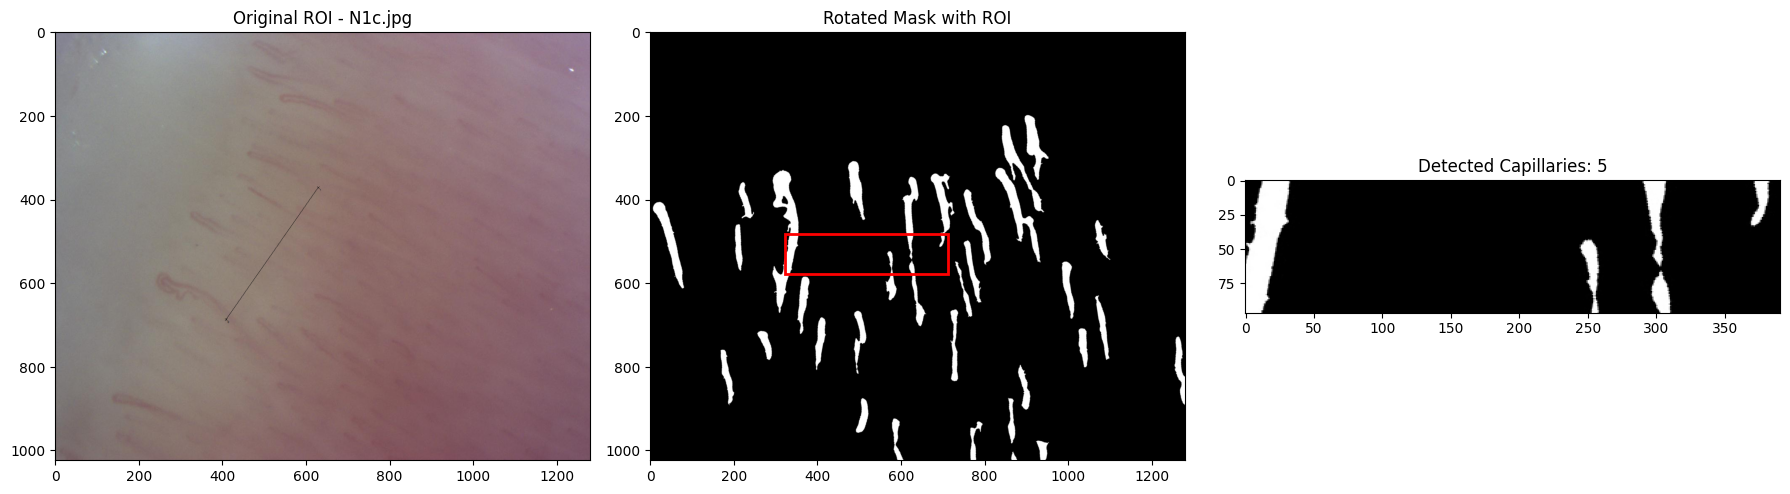

N1c.jpg: 5 capillaries detected in ROI


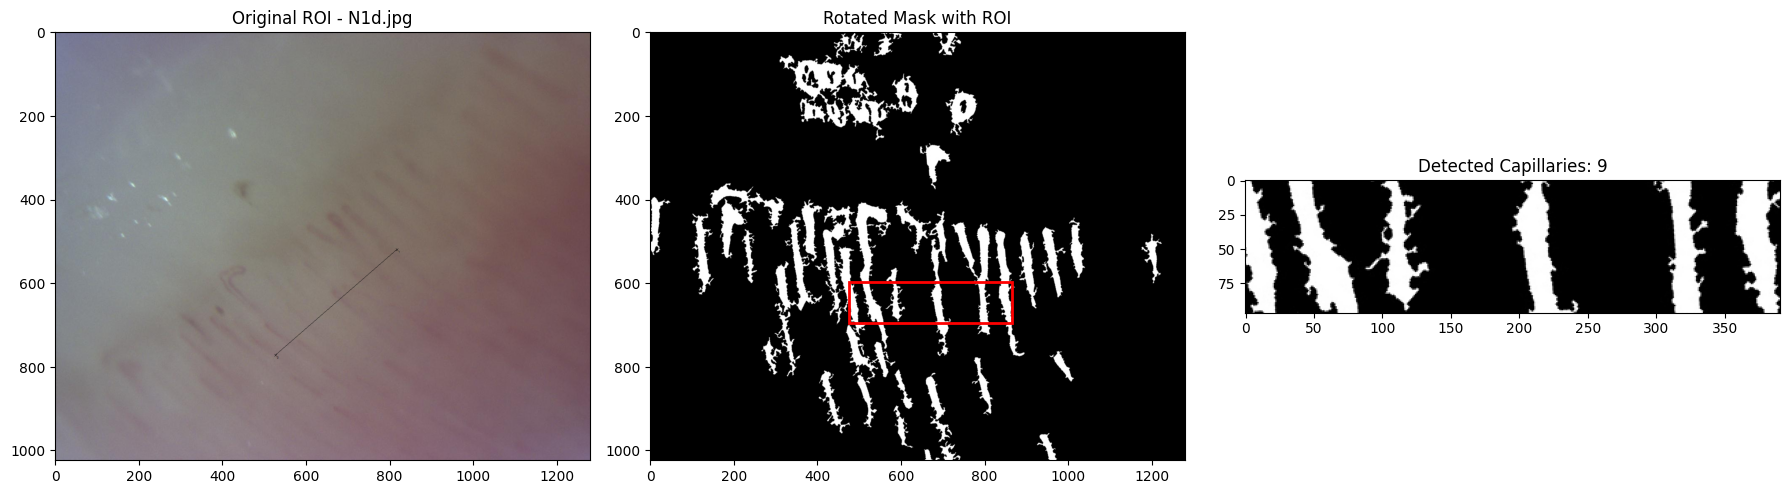

N1d.jpg: 9 capillaries detected in ROI


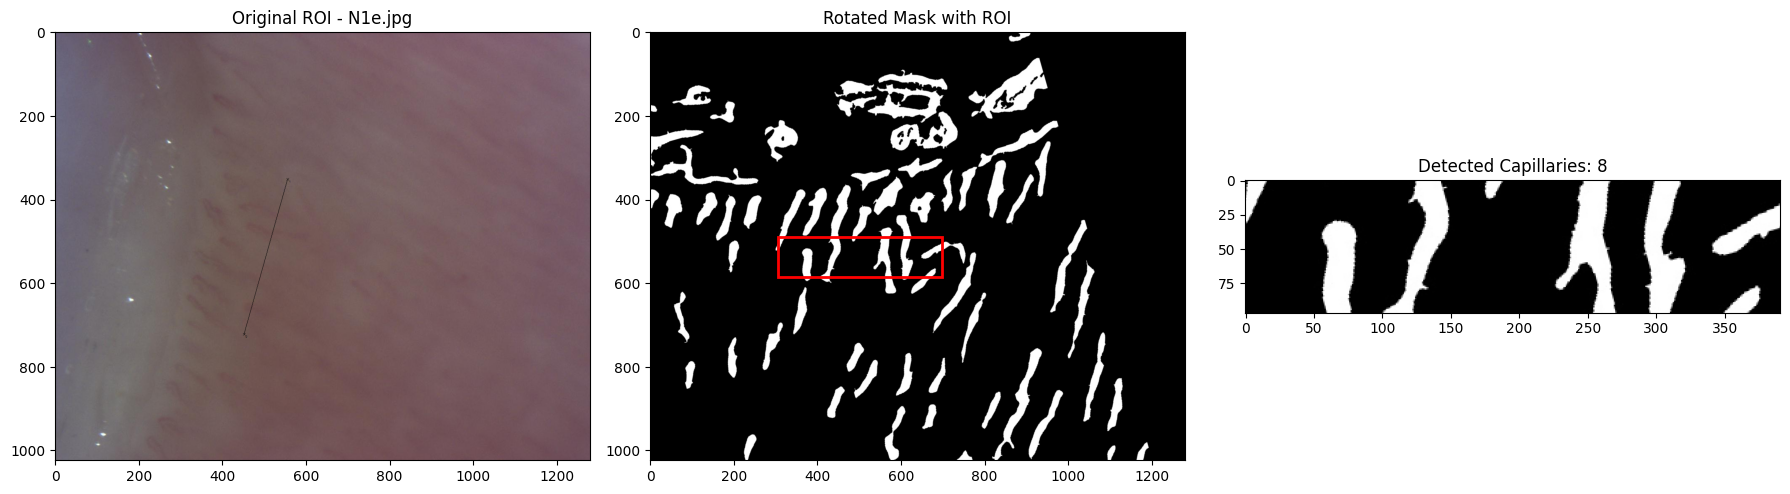

N1e.jpg: 8 capillaries detected in ROI


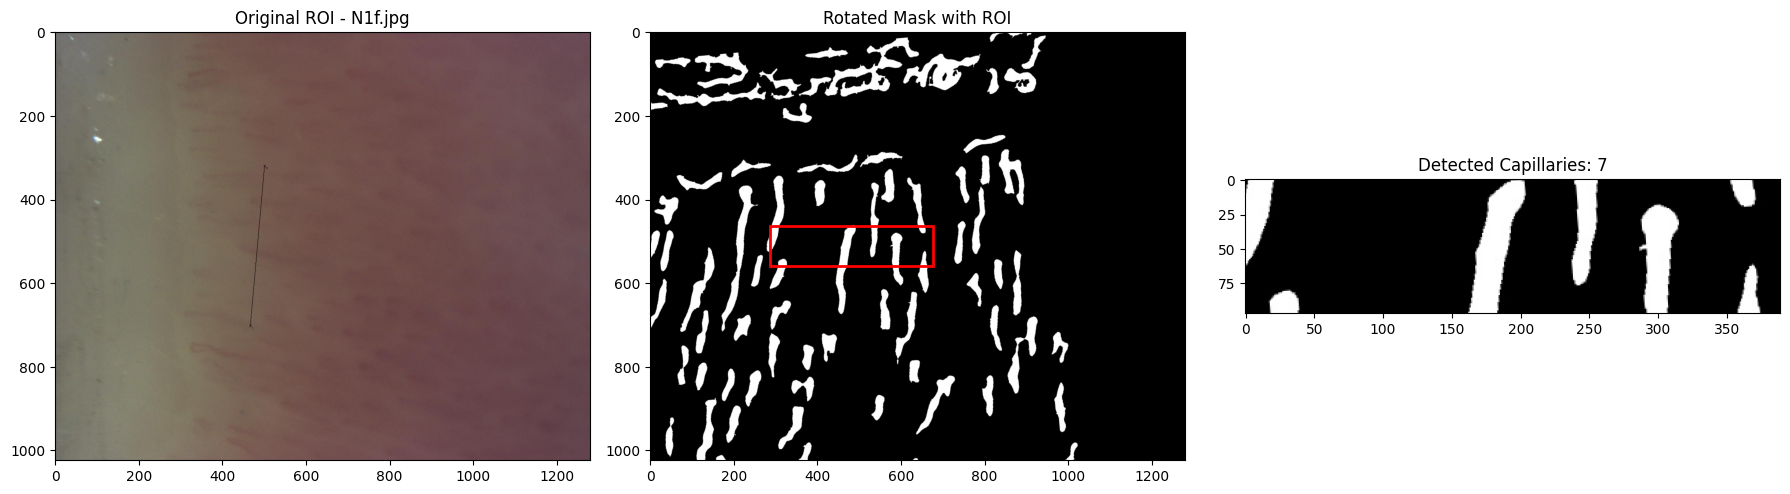

N1f.jpg: 7 capillaries detected in ROI


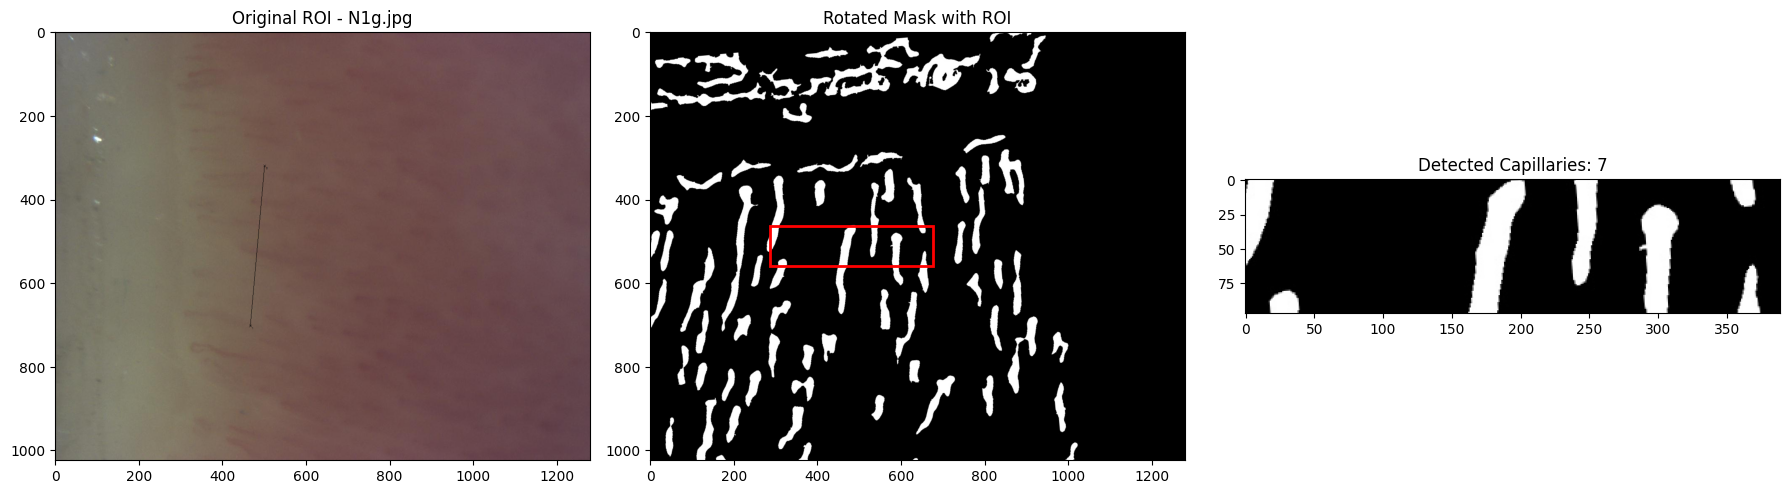

N1g.jpg: 7 capillaries detected in ROI


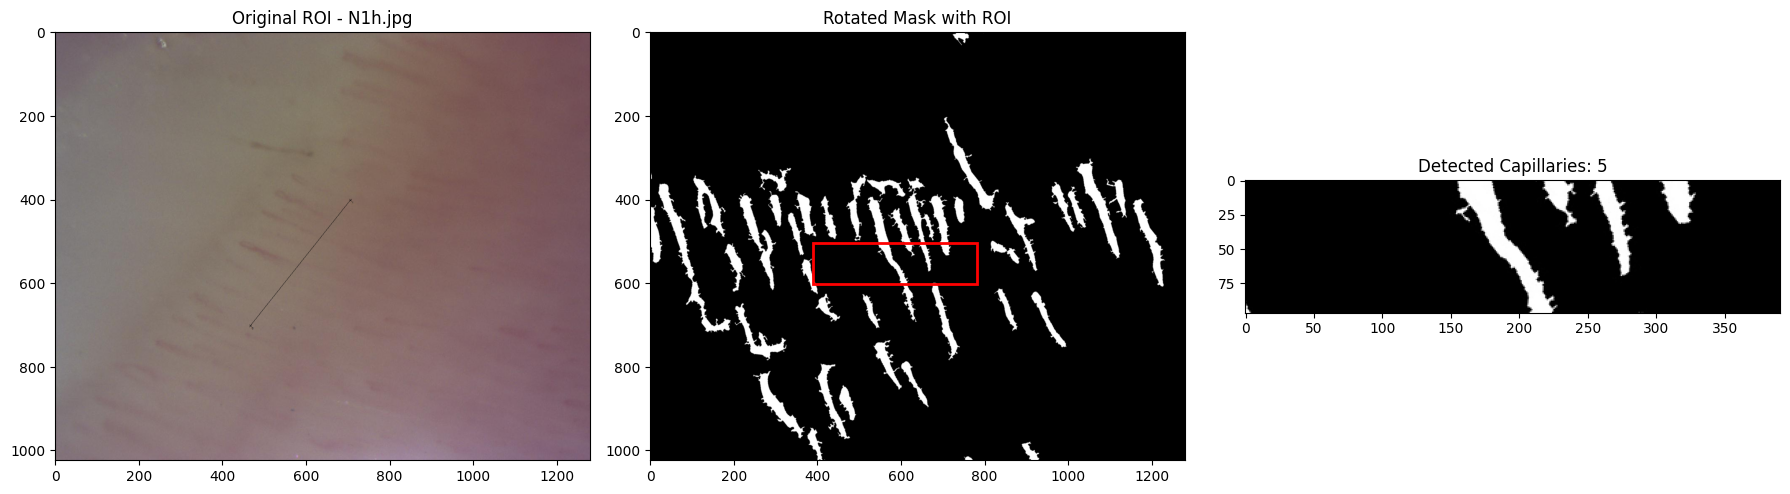

N1h.jpg: 5 capillaries detected in ROI


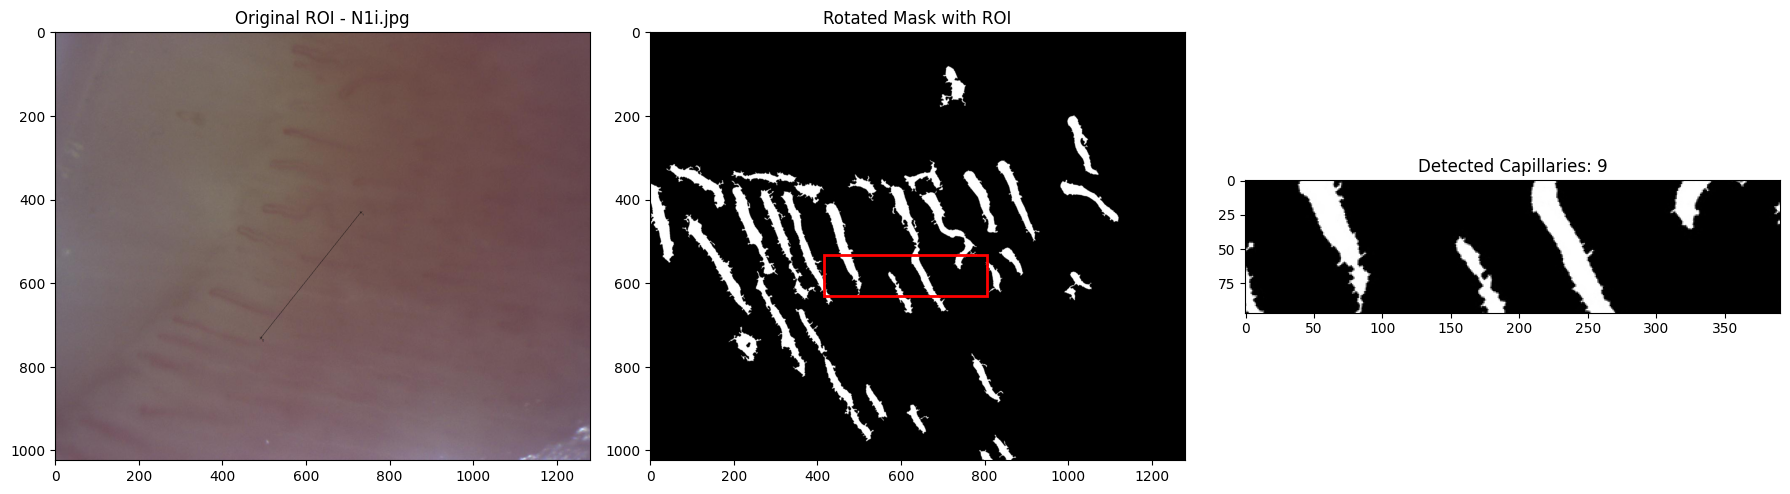

N1i.jpg: 9 capillaries detected in ROI


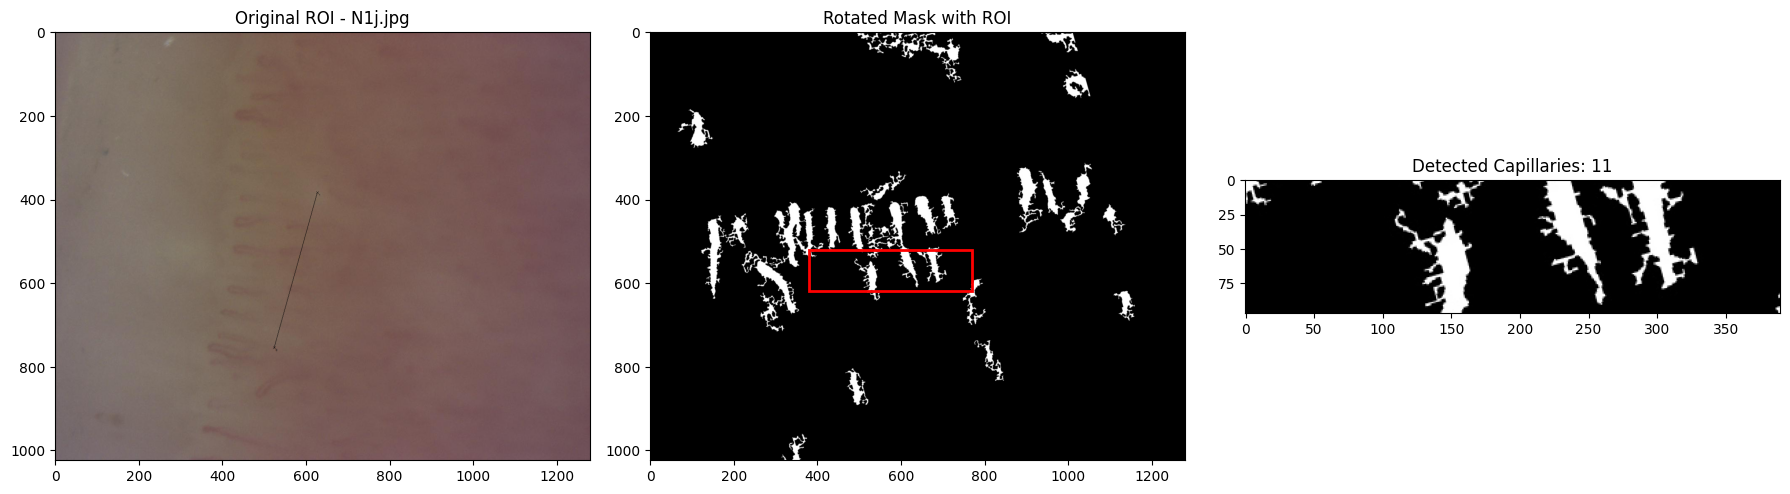

N1j.jpg: 11 capillaries detected in ROI


In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

roi_folder = 'Dataset/Region of Interest/N1_ROI'
mask_folder = 'Segmented/N1_Native_Segmentation/Masks'

def rotate_image(image, angle, center):
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]))
    return result, rot_mat

def apply_rotation_to_points(points, rot_mat):
    ones = np.ones(shape=(len(points), 1))
    points_ones = np.hstack([points, ones])
    rotated_points = rot_mat.dot(points_ones.T).T
    return rotated_points

def process_image(roi_path, mask_path, filename):
    roi_img = cv2.imread(roi_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if roi_img is None or mask_img is None:
        print(f"Error loading image: {filename}")
        return

    # Step 1: Detect black line in ROI
    gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    # Find contours (black line)
    contours, _ = cv2.findContours(thresh, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No black line found in {filename}")
        return

    black_line = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(black_line)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Get center and angle for rotation
    center = tuple(np.mean(box, axis=0))
    angle = rect[2]
    if rect[1][0] < rect[1][1]:
        angle = angle - 90  # Correct angle for horizontal alignment

    # Rotate both images
    rotated_roi, rot_mat = rotate_image(roi_img, angle, center)
    rotated_mask, _ = rotate_image(mask_img, angle, center)

    # Step 2: Calculate bounding box dimensions
    box_rotated = apply_rotation_to_points(box, rot_mat).astype(int)
    x_min, y_min = np.min(box_rotated, axis=0)
    x_max, y_max = np.max(box_rotated, axis=0)

    length = int(np.linalg.norm(box_rotated[0] - box_rotated[1]))
    width = int(length / 4)  # adjust based on your requirement

    # Step 3: Define final bounding box centered on the line
    mid_y = int((y_min + y_max) / 2)
    mid_x = int((x_min + x_max) / 2)
    top_left_x = mid_x - length // 2
    top_left_y = mid_y - width // 2

    roi_crop = rotated_mask[top_left_y:top_left_y+width, top_left_x:top_left_x+length]

    # Count connected components inside cropped mask
    _, binary = cv2.threshold(roi_crop, 127, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(binary)

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    ax[0].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original ROI - {filename}")

    ax[1].imshow(rotated_mask, cmap='gray')
    ax[1].add_patch(Rectangle((top_left_x, top_left_y), length, width, linewidth=2, edgecolor='r', facecolor='none'))
    ax[1].set_title("Rotated Mask with ROI")

    ax[2].imshow(roi_crop, cmap='gray')
    ax[2].set_title(f"Detected Capillaries: {num_labels - 1}")

    plt.tight_layout()
    plt.show()

    print(f"{filename}: {num_labels - 1} capillaries detected in ROI")

# Main processing loop
for filename in sorted(os.listdir(roi_folder)):
    if filename.endswith('.jpg'):
        roi_path = os.path.join(roi_folder, filename)
        mask_name = filename.replace('.jpg', '_Natif.jpg')
        mask_path = os.path.join(mask_folder, mask_name)
        process_image(roi_path, mask_path, filename)


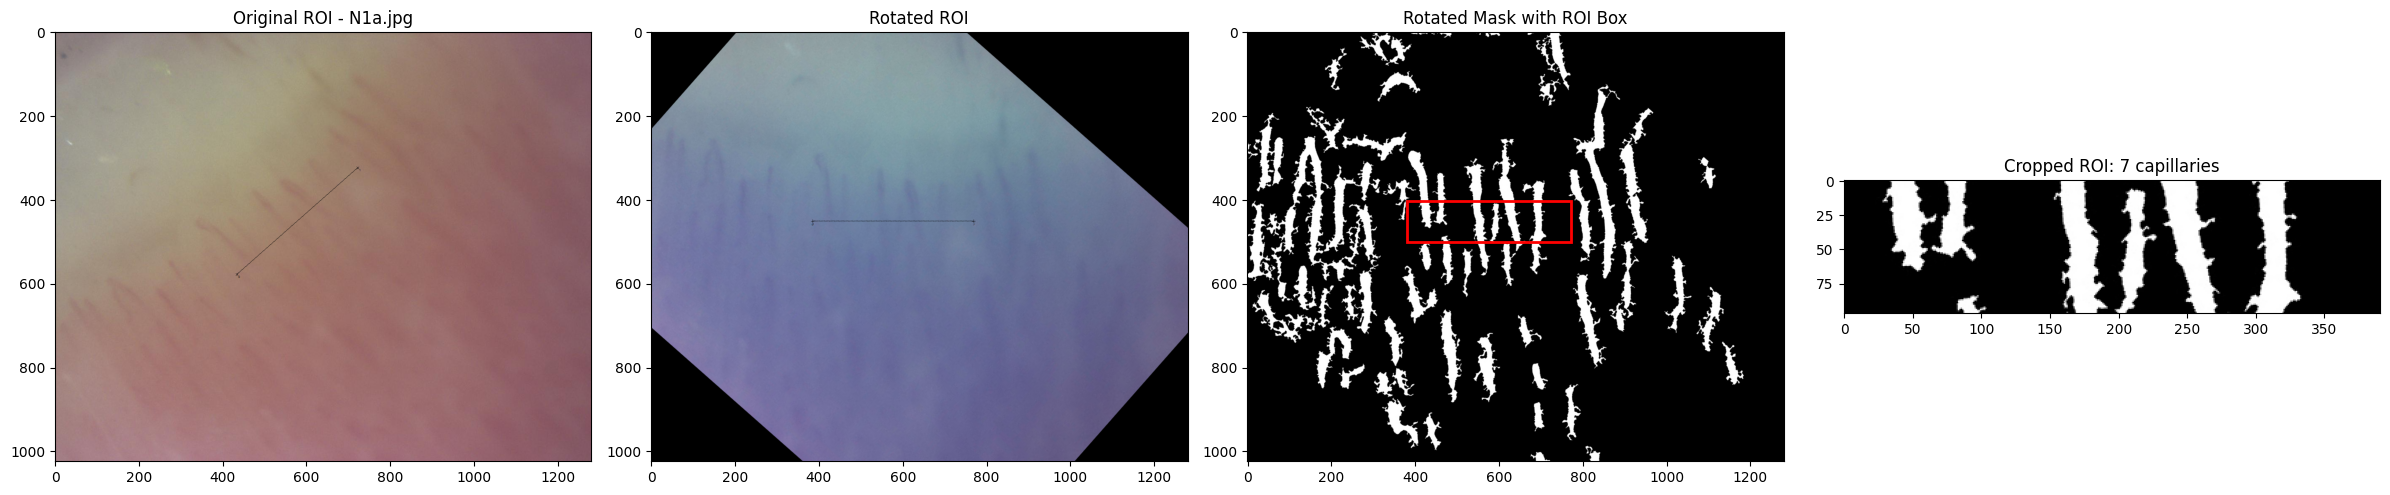

N1a.jpg: 7 capillaries detected in ROI


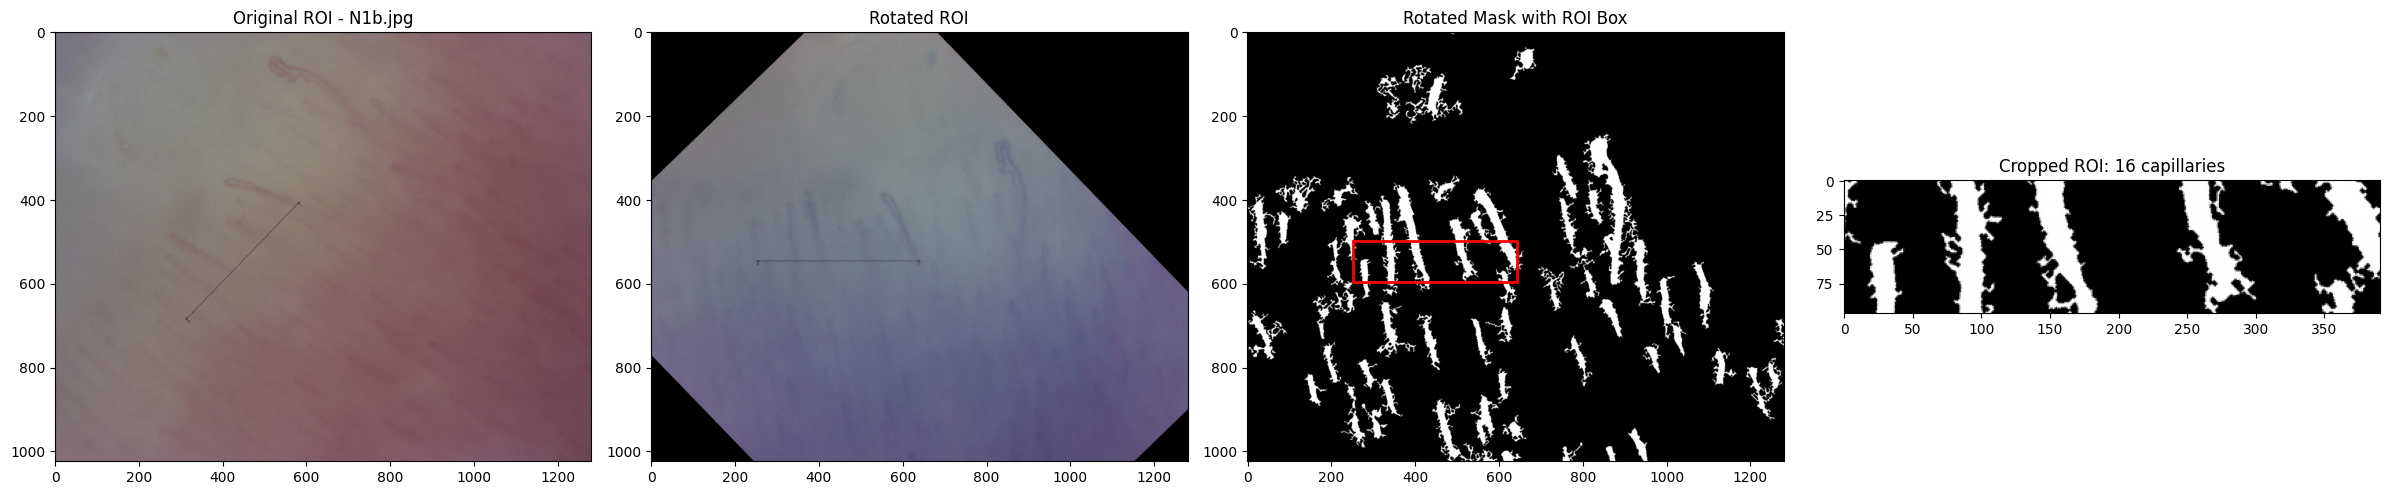

N1b.jpg: 16 capillaries detected in ROI


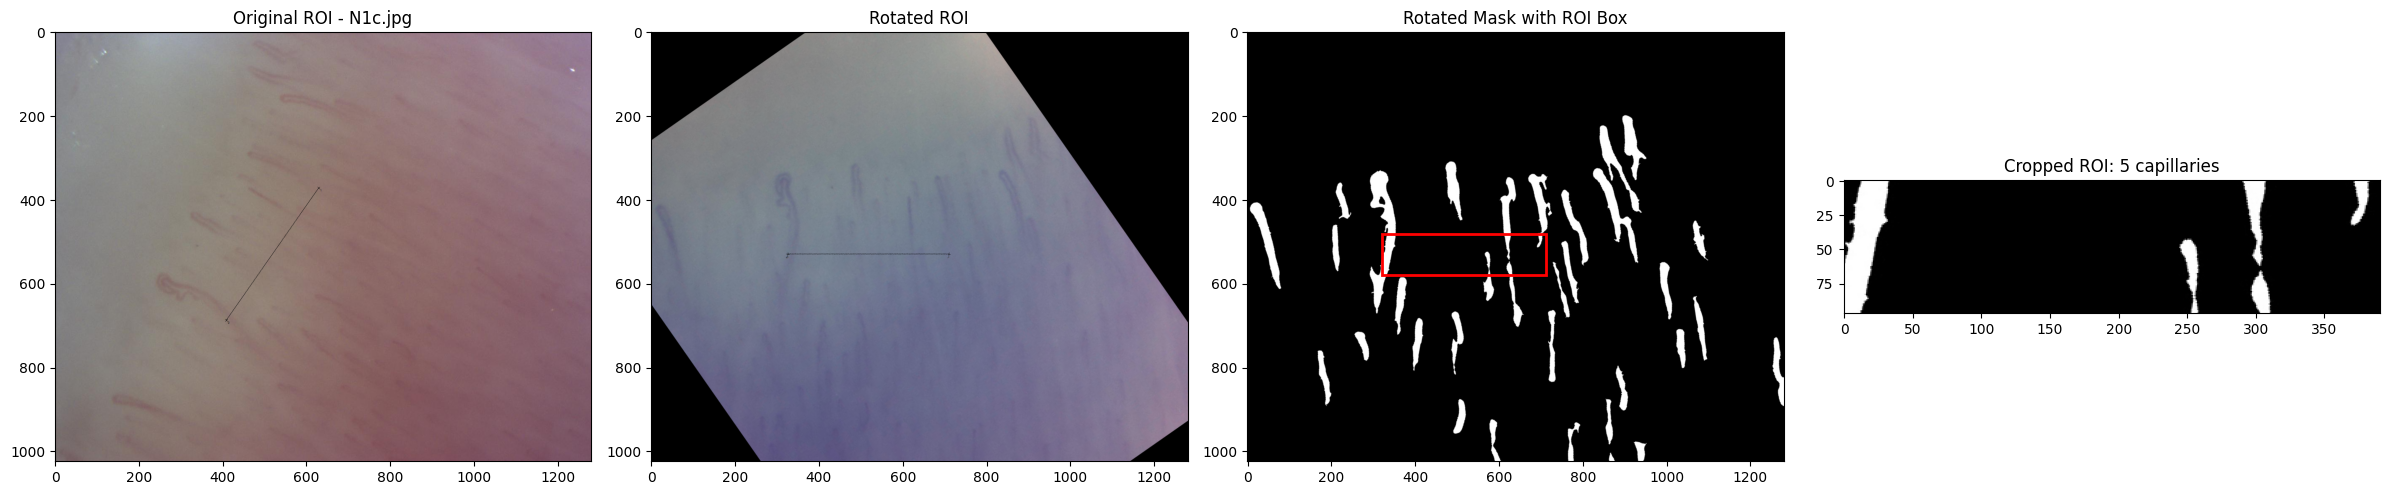

N1c.jpg: 5 capillaries detected in ROI


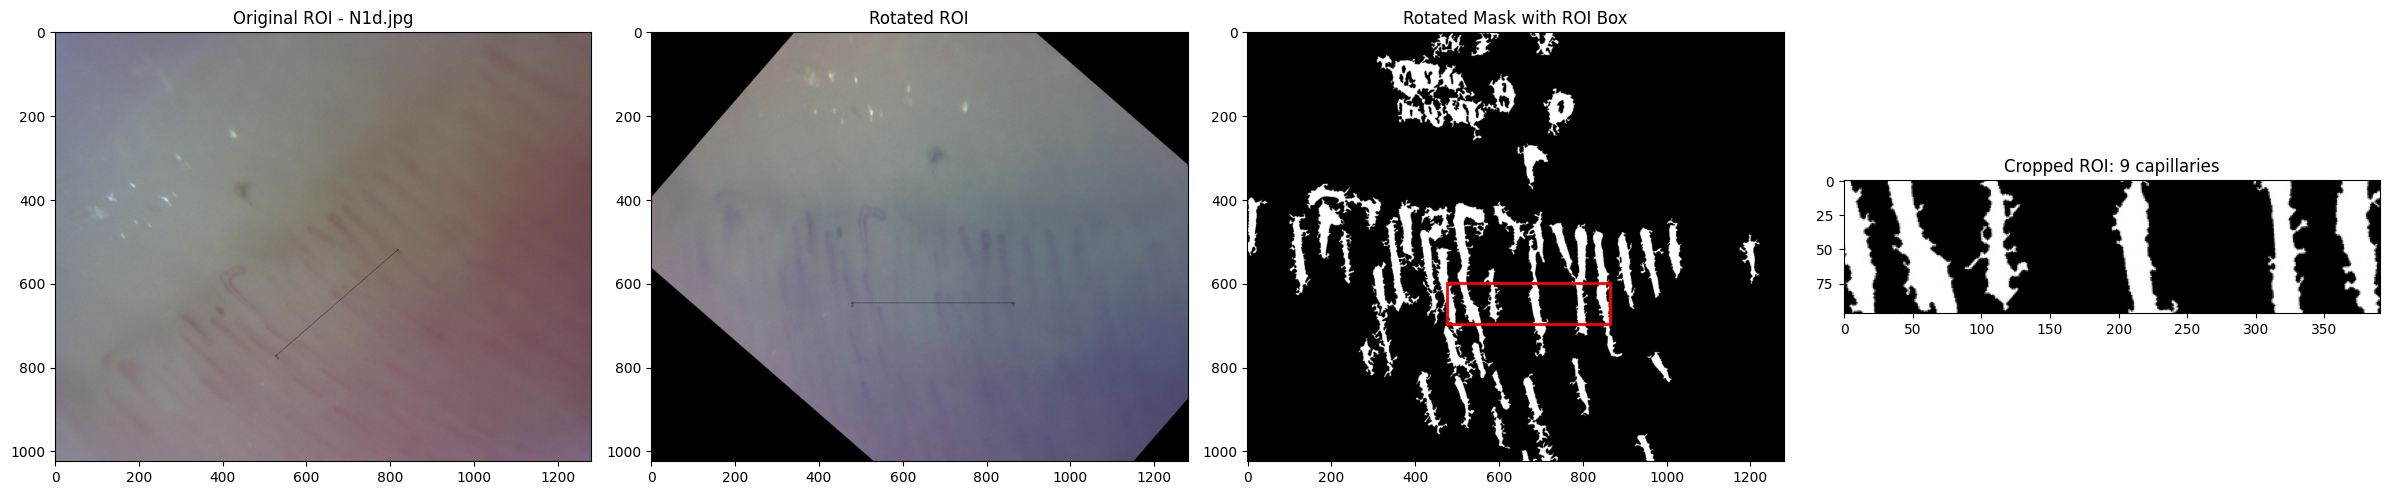

N1d.jpg: 9 capillaries detected in ROI


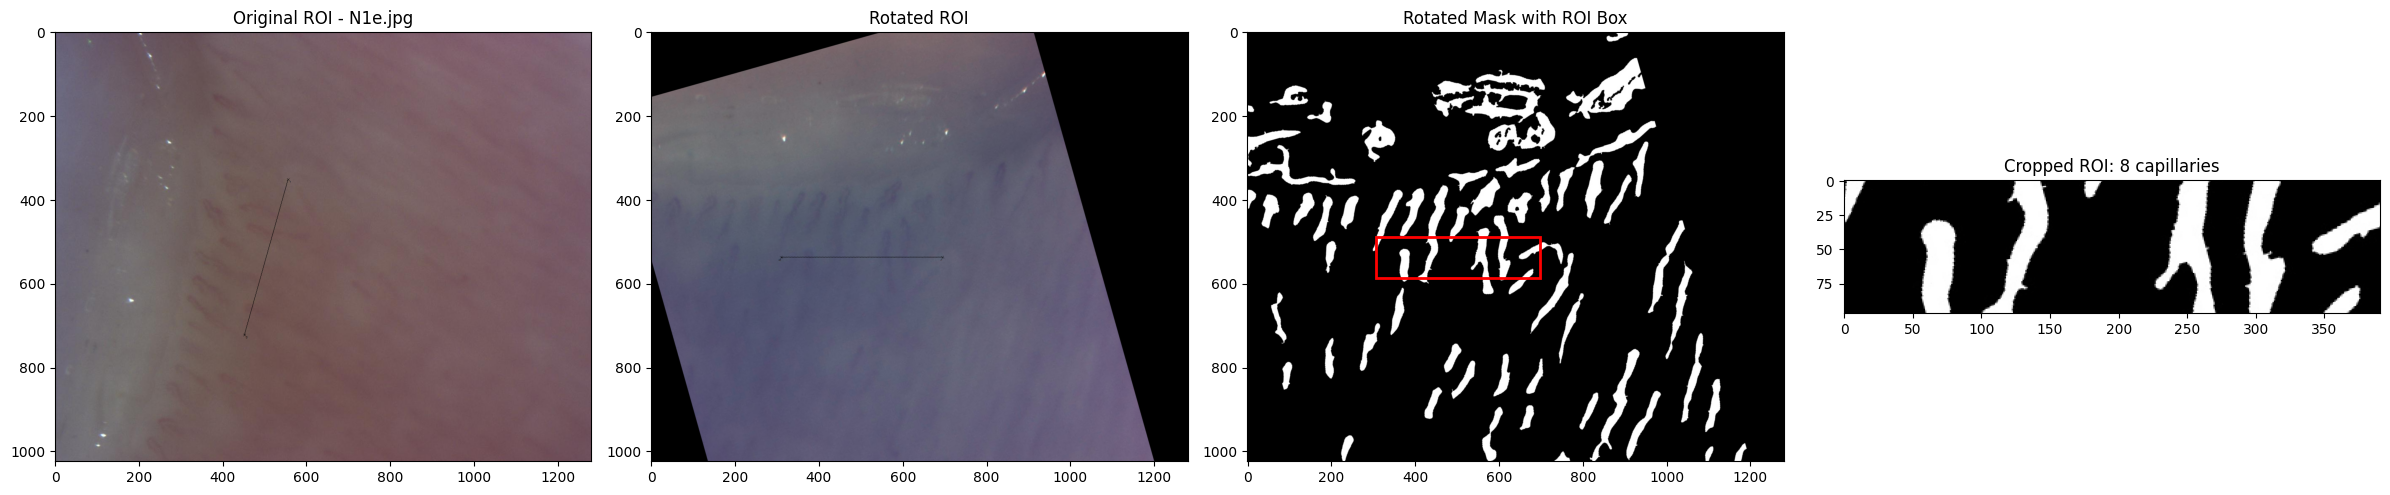

N1e.jpg: 8 capillaries detected in ROI


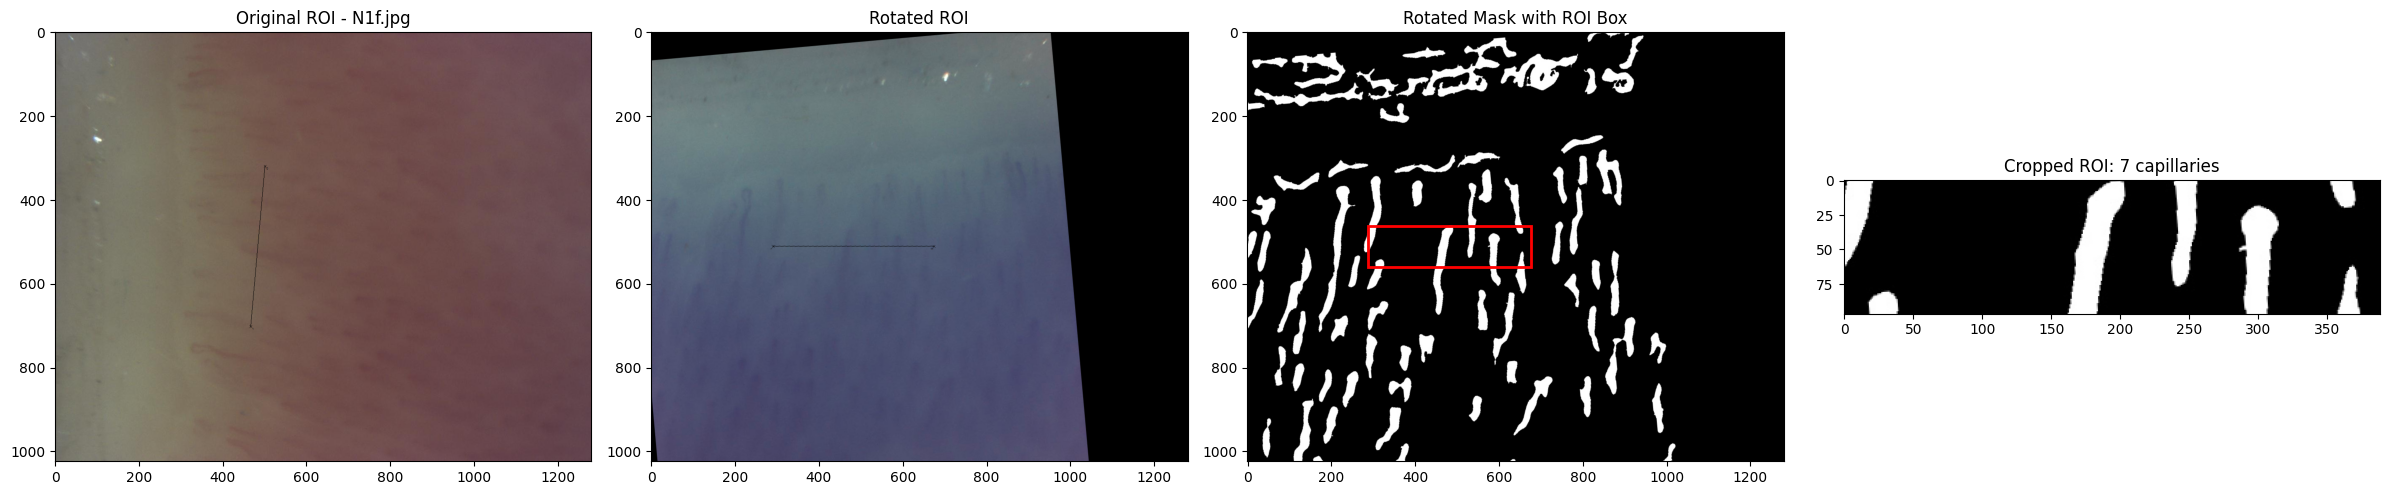

N1f.jpg: 7 capillaries detected in ROI


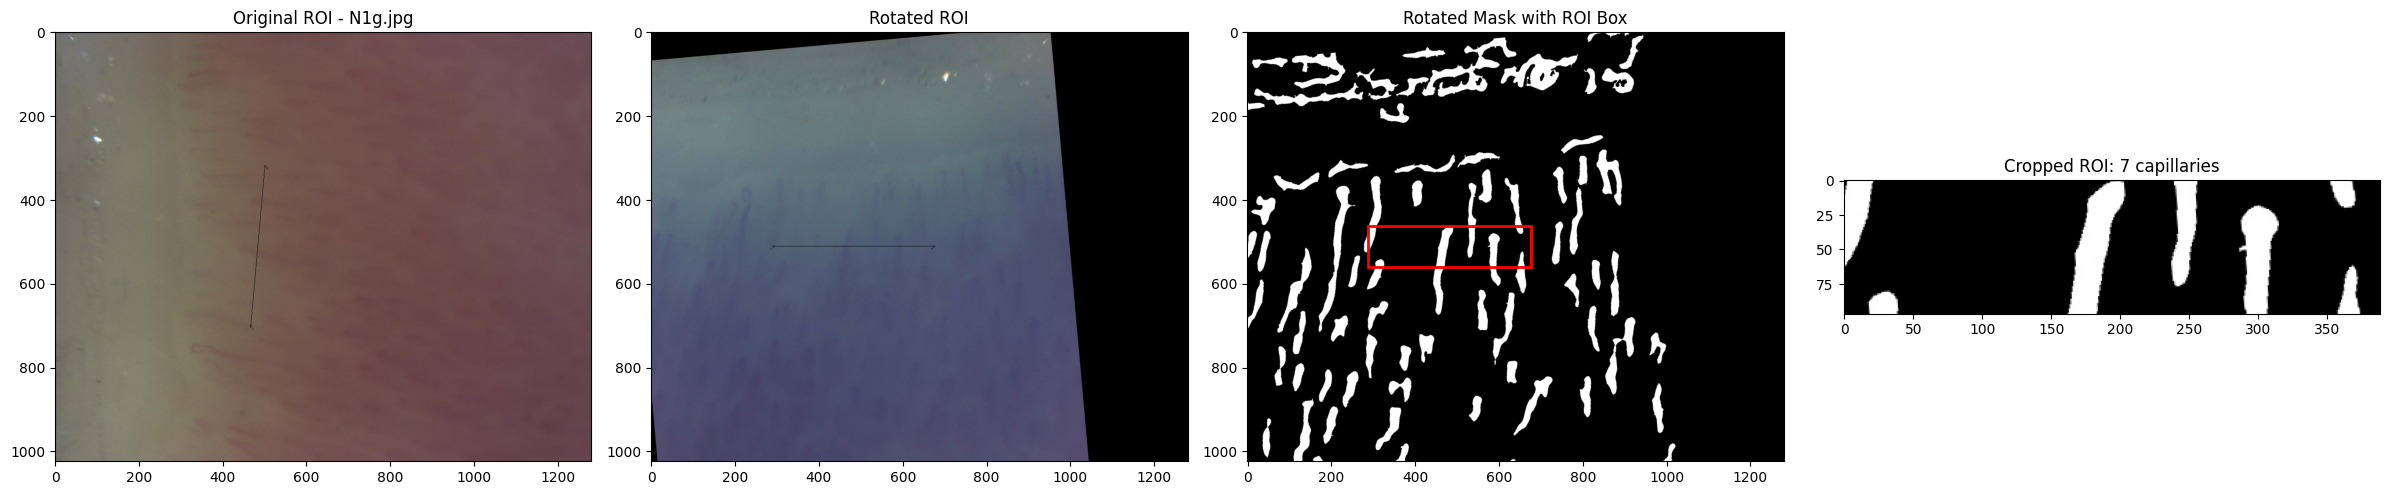

N1g.jpg: 7 capillaries detected in ROI


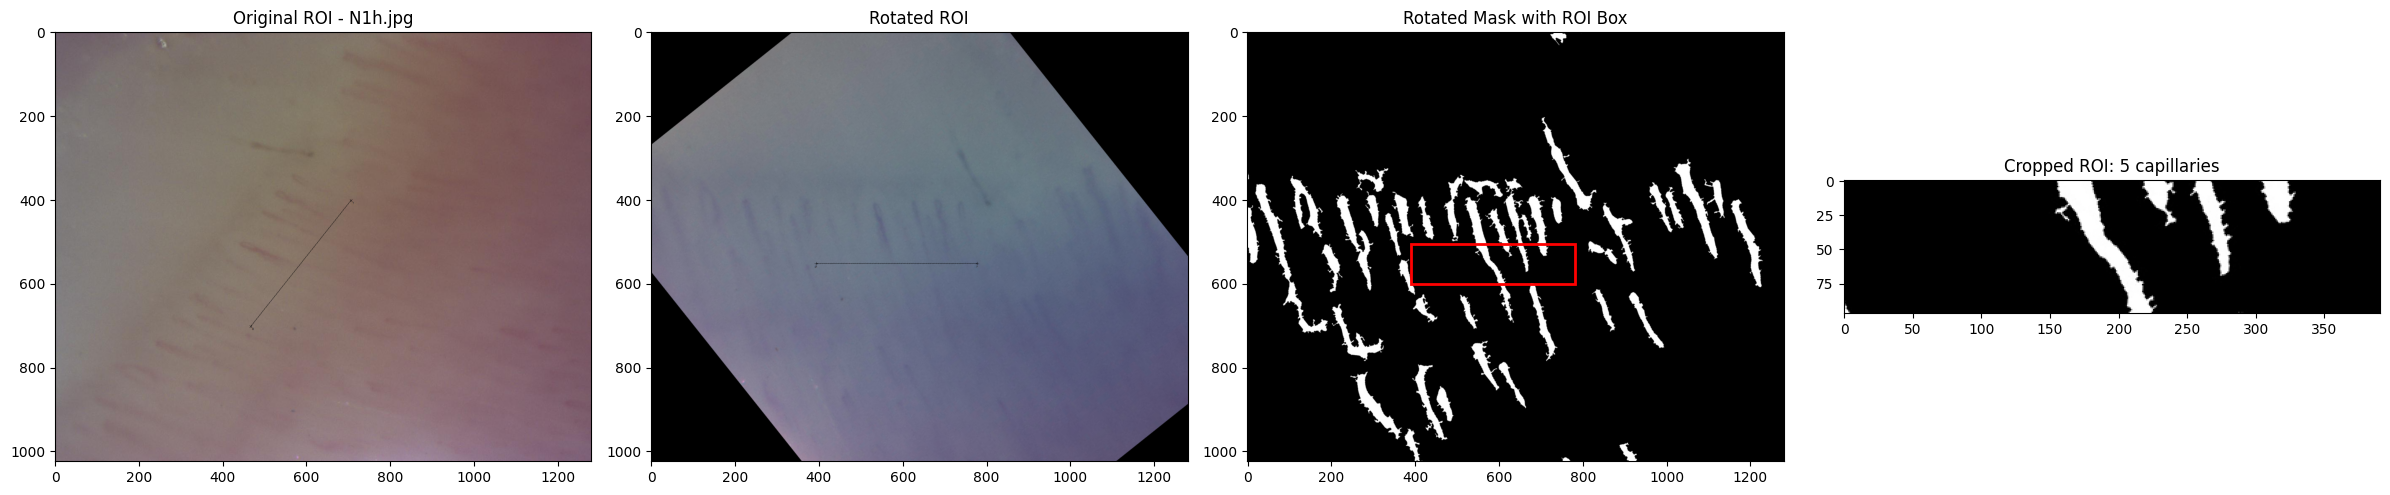

N1h.jpg: 5 capillaries detected in ROI


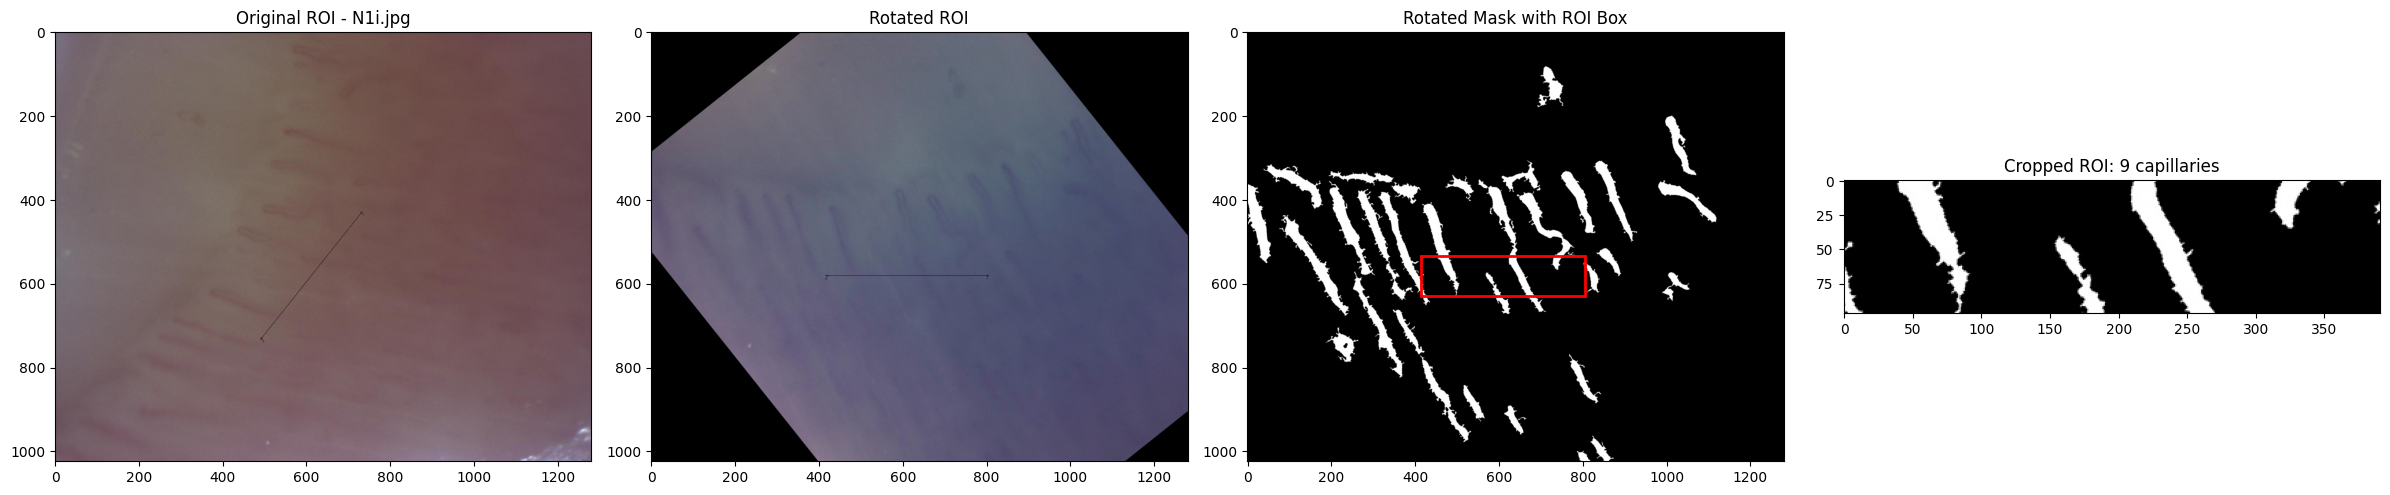

N1i.jpg: 9 capillaries detected in ROI


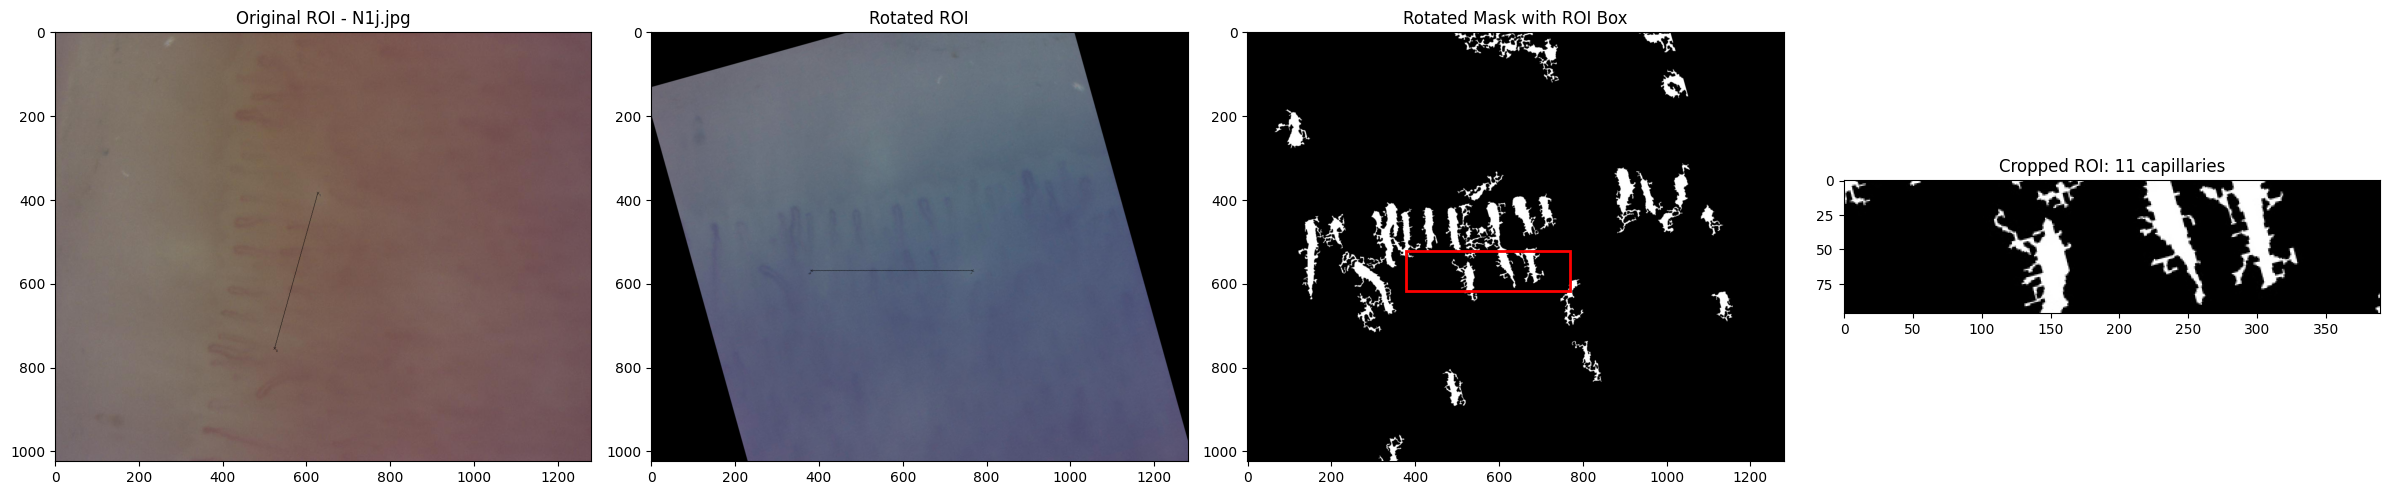

N1j.jpg: 11 capillaries detected in ROI
✅ Results saved to capillary_counts.csv


In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle

roi_folder = 'Dataset/Region of Interest/N1_ROI'
mask_folder = 'Segmented/N1_Native_Segmentation/Masks'
results = []

def rotate_image(image, angle, center):
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]))
    return result, rot_mat

def apply_rotation_to_points(points, rot_mat):
    ones = np.ones(shape=(len(points), 1))
    points_ones = np.hstack([points, ones])
    rotated_points = rot_mat.dot(points_ones.T).T
    return rotated_points

def process_image(roi_path, mask_path, filename):
    roi_img = cv2.imread(roi_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if roi_img is None or mask_img is None:
        print(f"Error loading image: {filename}")
        return

    # Step 1: Detect black line in ROI
    gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No black line found in {filename}")
        return

    black_line = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(black_line)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    center = tuple(np.mean(box, axis=0))
    angle = rect[2]
    if rect[1][0] < rect[1][1]:
        angle = angle - 90

    # Rotate both images
    rotated_roi, rot_mat = rotate_image(roi_img, angle, center)
    rotated_mask, _ = rotate_image(mask_img, angle, center)

    # Step 2: Calculate bounding box dimensions
    box_rotated = apply_rotation_to_points(box, rot_mat).astype(int)
    x_min, y_min = np.min(box_rotated, axis=0)
    x_max, y_max = np.max(box_rotated, axis=0)

    length = int(np.linalg.norm(box_rotated[0] - box_rotated[1]))
    width = int(length / 4)

    # Step 3: Define final bounding box
    mid_y = int((y_min + y_max) / 2)
    mid_x = int((x_min + x_max) / 2)
    top_left_x = mid_x - length // 2
    top_left_y = mid_y - width // 2

    roi_crop = rotated_mask[top_left_y:top_left_y+width, top_left_x:top_left_x+length]

    # Count connected components inside cropped mask
    _, binary = cv2.threshold(roi_crop, 127, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(binary)

    # Save results
    results.append({'filename': filename, 'capillary_count': num_labels - 1})

    # Visualization (4 subplots now)
    fig, ax = plt.subplots(1, 4, figsize=(24, 5))
    ax[0].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original ROI - {filename}")

    ax[1].imshow(rotated_roi, cmap='gray')
    ax[1].set_title("Rotated ROI")

    ax[2].imshow(rotated_mask, cmap='gray')
    ax[2].add_patch(Rectangle((top_left_x, top_left_y), length, width, linewidth=2, edgecolor='r', facecolor='none'))
    ax[2].set_title("Rotated Mask with ROI Box")

    ax[3].imshow(roi_crop, cmap='gray')
    ax[3].set_title(f"Cropped ROI: {num_labels - 1} capillaries")

    plt.tight_layout()
    plt.show()

    print(f"{filename}: {num_labels - 1} capillaries detected in ROI")

# Main loop
for filename in sorted(os.listdir(roi_folder)):
    if filename.endswith('.jpg'):
        roi_path = os.path.join(roi_folder, filename)
        mask_name = filename.replace('.jpg', '_Natif.jpg')
        mask_path = os.path.join(mask_folder, mask_name)
        process_image(roi_path, mask_path, filename)

# Export to CSV
df = pd.DataFrame(results)
df.to_csv('capillary_counts.csv', index=False)
print("✅ Results saved to capillary_counts.csv")
